In [456]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa as tsa
import statsmodels as sm
from datetime import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Getting the dataset

In [457]:
data = pd.read_excel("IMPORTACION-VOLUMEN-2024-05.xlsx", index_col="Fecha", parse_dates=["Fecha"], date_format="%Y-%m-%d ", skiprows=6, skipfooter=3)

import_data = data[['Gasolina regular', 'Gasolina superior', 'Gas licuado de petróleo']]
import_data

,Gasolina regular,Gasolina superior,Gas licuado de petróleo
Fecha,,,
2001-01-01 00:00:00,177776.50,373963.96,194065.738095
2001-02-01 00:00:00,123115.99,243091.07,170703.380952
2001-03-01 00:00:00,161726.42,312084.38,161837.371429
2001-04-01 00:00:00,127338.74,285054.89,163048.642857
2001-05-01 00:00:00,168730.19,300913.67,171518.861905
...,...,...,...
2024-01-01 00:00:00,914133.32,712333.33,701570.800000
2024-02-01 00:00:00,740662.25,650360.11,916541.700000
2024-03-01 00:00:00,838270.93,620077.74,675157.480000


### Transformation of Diesel column

In [458]:
start_date = '2017-12-01'

import_data['Diesel'] = np.where((data.index <= start_date),
                                    data['Diesel alto azufre'],
                                    data['Diesel bajo azufre'])

import_data['Diesel']

/var/folders/nh/qxcg2qs54dq8v4tnbxqzpm7w0000gn/T/ipykernel_7608/2775745780.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import_data['Diesel'] = np.where((data.index <= start_date),


Fecha
2001-01-01 00:00:00     566101.99
2001-02-01 00:00:00     489525.80
2001-03-01 00:00:00     575559.68
2001-04-01 00:00:00     437745.42
2001-05-01 00:00:00     552609.13
                          ...    
2024-01-01 00:00:00    1409097.15
2024-02-01 00:00:00    1236861.75
2024-03-01 00:00:00    1477038.00
2024-04-01 00:00:00    1294706.12
2024-05-01 00:00:00    1470870.09
Name: Diesel, Length: 281, dtype: float64

### Getting beginning, ending and frequency of the Time Series

In [459]:
inicio = min(import_data.index)
inicio
values = import_data.loc[inicio]
print("Fecha: ", inicio, "Valor: ", values['Gasolina superior'])

Fecha:  2001-01-01 00:00:00 Valor:  373963.96


In [460]:
fin = max(import_data.index)
fin
values = import_data.loc[fin]
print("Fecha: ", fin, "Valor: ", values['Gasolina superior'])

Fecha:  2024-05-01 00:00:00 Valor:  696970.3


In [461]:
infer_frec = pd.infer_freq(import_data['Gasolina superior'].index)
infer_frec

'MS'

In [462]:
# Replace zero values with NaN
import_data = import_data.replace(0, np.nan)

# Drop rows with NaN values (which were originally zero values)
import_data = import_data.dropna()

/var/folders/nh/qxcg2qs54dq8v4tnbxqzpm7w0000gn/T/ipykernel_7608/1110981822.py:10: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  import_data_yearly = import_data.resample('Y').sum()


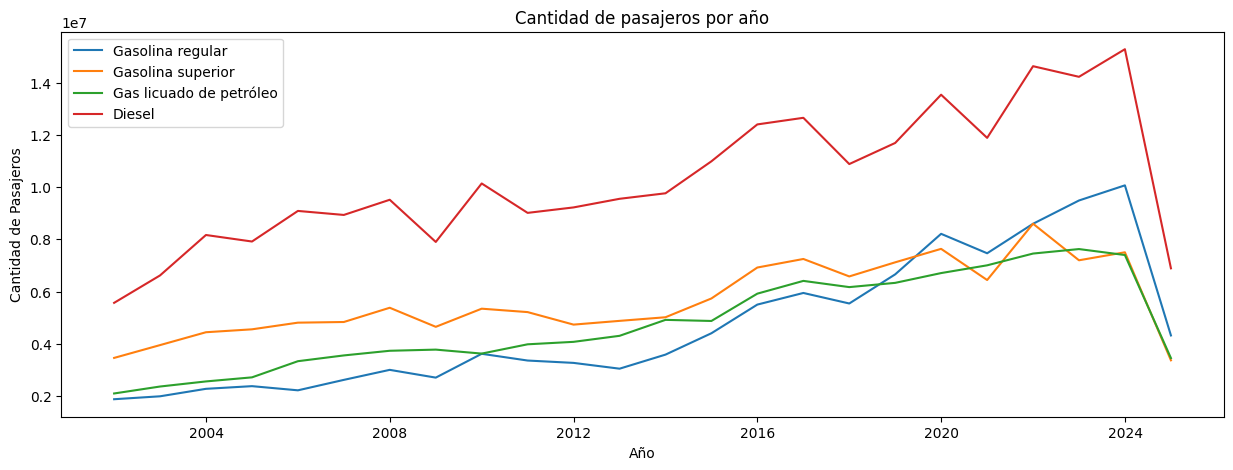

In [463]:
import matplotlib.dates as mdates

# Assuming consume_data is already loaded

# Ensure the index is a DatetimeIndex
if not isinstance(import_data.index, pd.DatetimeIndex):
    import_data.index = pd.to_datetime(import_data.index)

# Group the data by year and sum the values
import_data_yearly = import_data.resample('Y').sum()

# Plot the aggregated data
plt.plot(import_data_yearly)

# Set the title and labels
plt.gca().set(title="Cantidad de pasajeros por año", xlabel="Año", ylabel="Cantidad de Pasajeros")

# Format the x-axis to display only the year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add a legend
plt.legend(import_data.columns)

### Plotting Time Series behavier with selected fields

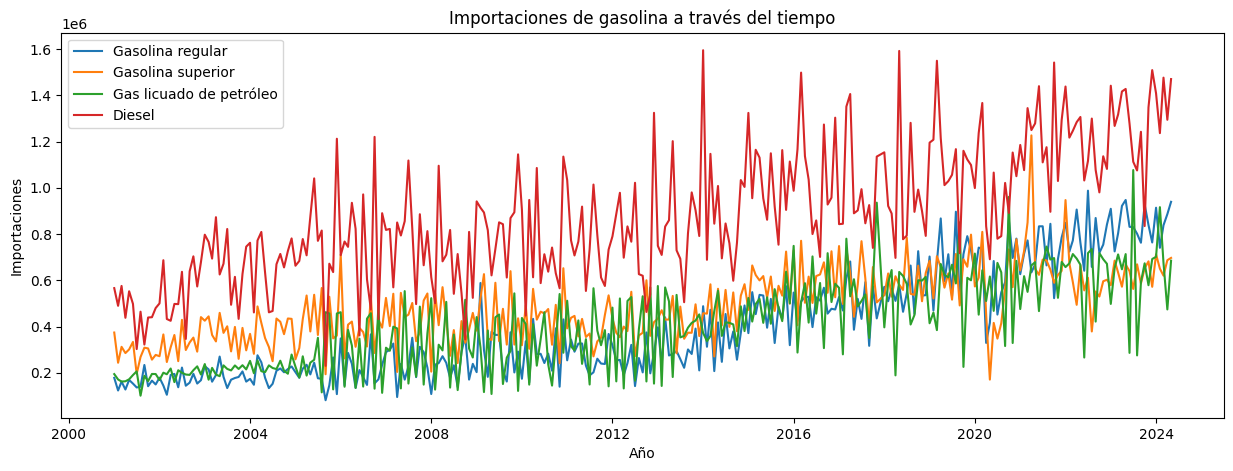

In [464]:
plt.plot(import_data)
plt.gca().set(title="Importaciones de gasolina a través del tiempo", xlabel="Año", ylabel="Importaciones")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend(import_data.columns)
plt.show()

In [465]:
import_data = import_data['Gasolina superior']
train_import_data = import_data[:'2020']
test_import_data = import_data['2020':]

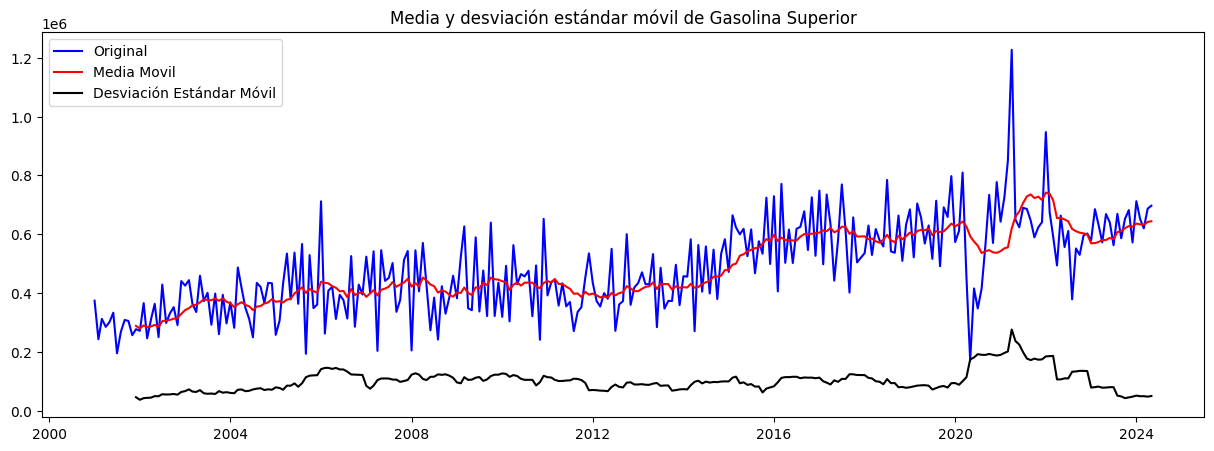

In [466]:
# Se calcula la media móvil y la desviación estandar móvil de los últimos 12 meses.
mediaMovil = import_data.rolling(window=12).mean()
deMovil = import_data.rolling(window=12).std()
# Se grafican los resultados.
original = plt.plot(import_data, color="blue", label="Original")
media = plt.plot(mediaMovil, color='red', label = 'Media Movil')
ds = plt.plot(deMovil,color='black', label = 'Desviación Estándar Móvil')
plt.legend(loc = 'best')
plt.title('Media y desviación estándar móvil de Gasolina Superior')
plt.show(block=False)

### Looking for posible tendency in series

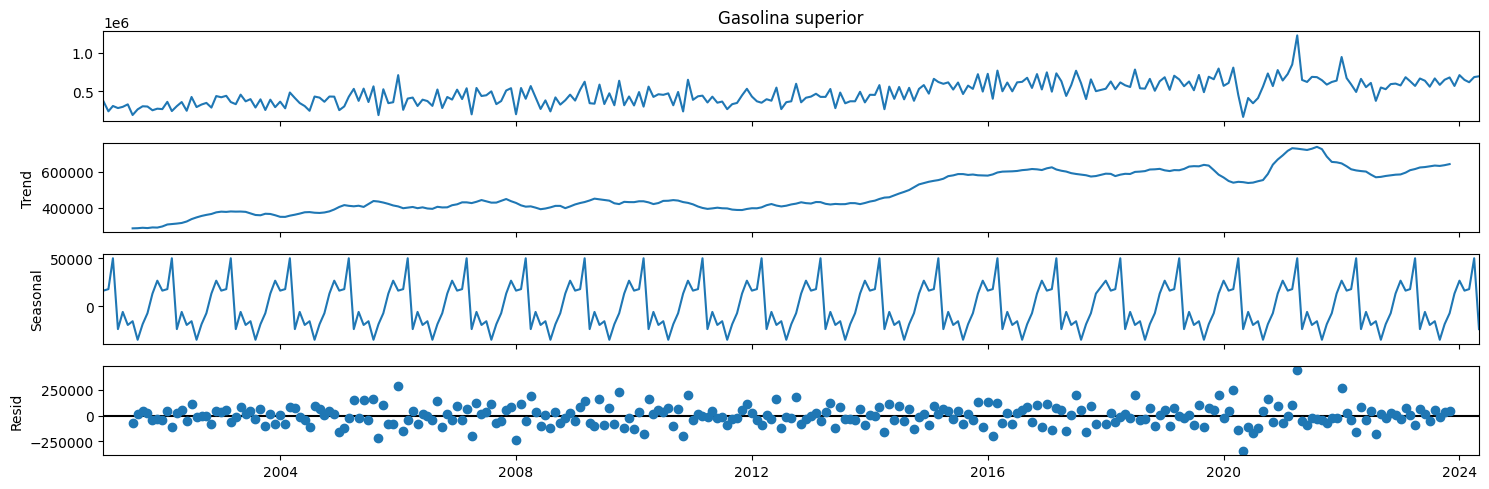

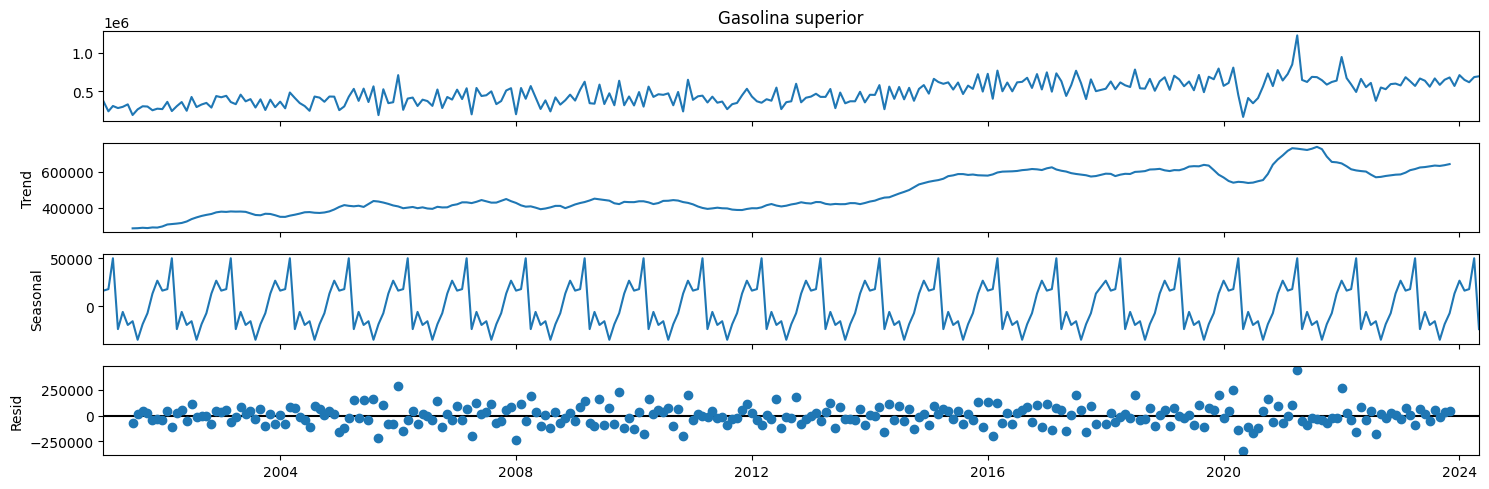

In [467]:
descomposicion = seasonal_decompose(import_data, model='additive', period=12)
descomposicion.plot()

### Looking for unitarian roots

In [468]:
print('Resultados del Test de Dickey Fuller')
dfTest = adfuller(import_data, autolag='AIC')
salidaDf = pd.Series(dfTest[0:4], index=['Estadístico de prueba','p-value','# de retardos usados','# de observaciones usadas'])
for key,value in dfTest[4].items():
        salidaDf['Critical Value (%s)'%key] = value
print(salidaDf)

Resultados del Test de Dickey Fuller
Estadístico de prueba         -2.923066
p-value                        0.042731
# de retardos usados           3.000000
# de observaciones usadas    276.000000
Critical Value (1%)           -3.454267
Critical Value (5%)           -2.872070
Critical Value (10%)          -2.572381
dtype: float64


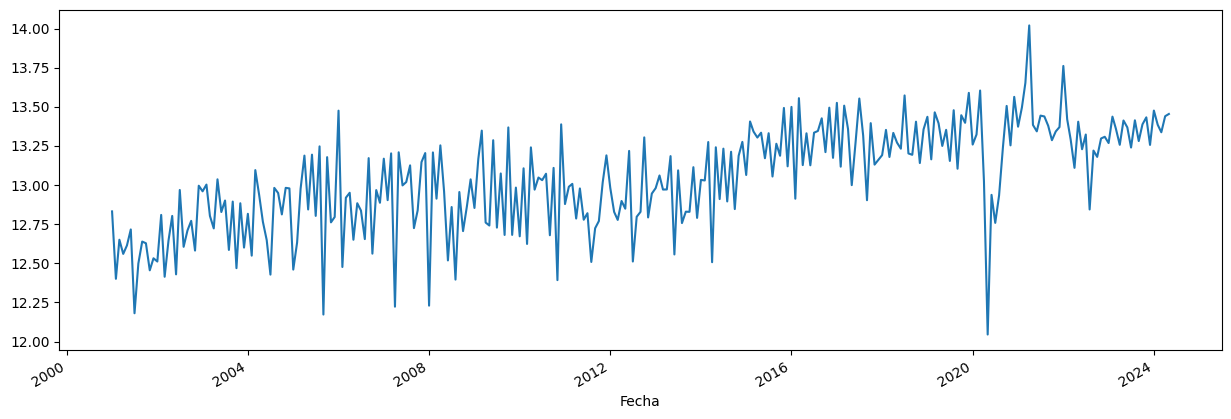

In [469]:
import_data_log = np.log(import_data)
import_data_log.plot()
import_data_log_diff = import_data_log.diff()
import_data_log_diff.dropna(inplace=True)

<Axes: xlabel='Fecha'>

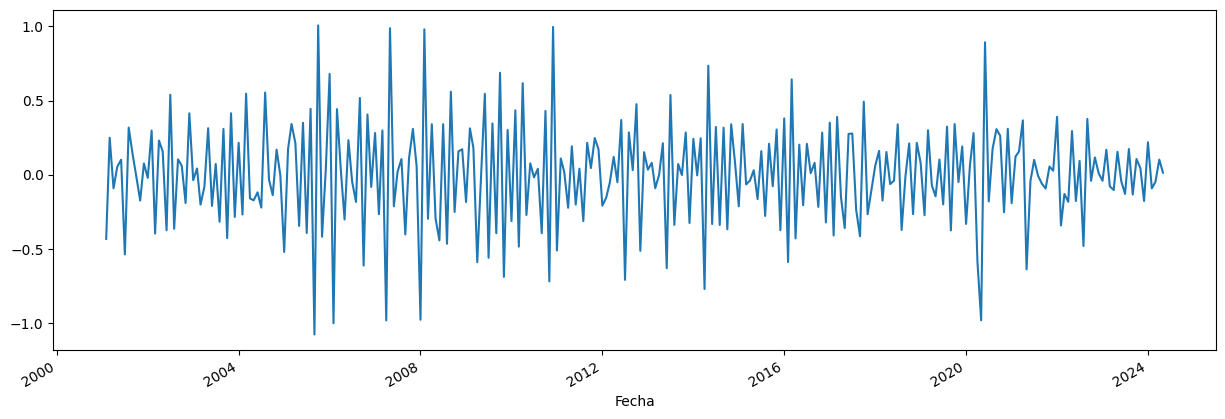

In [470]:
import_data_log_diff.plot()

### Finding the best parameters for ARMA or ARIMA models

Text(0.5, 1.0, 'Función de Autocorrelación Parcial 8 retardos')

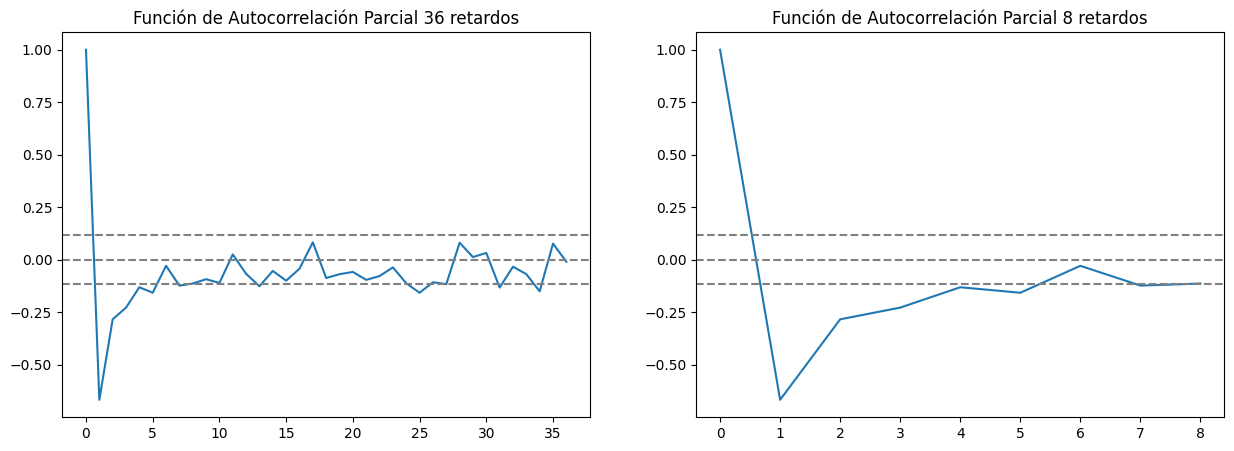

In [471]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

plt.subplot(121)
plt.plot(pacf(import_data_log_diff, nlags=36))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(import_data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(import_data_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 36 retardos')

plt.subplot(122)
plt.plot(pacf(import_data_log_diff, nlags=8))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(import_data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(import_data_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación Parcial 8 retardos')

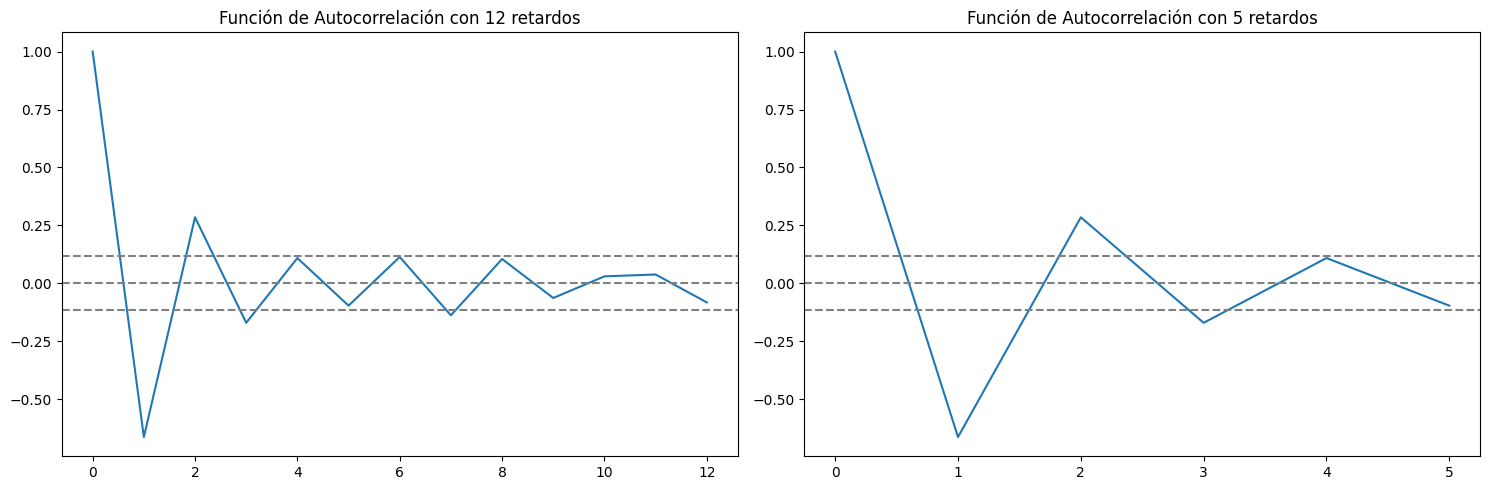

In [472]:

plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

#Plot ACF: 
plt.subplot(121) 
plt.plot(acf(import_data_log_diff,nlags=12,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(import_data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(import_data_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 12 retardos')

plt.subplot(122) 
plt.plot(acf(import_data_log_diff,nlags=5,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(import_data_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(import_data_log_diff)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 5 retardos')

plt.tight_layout()

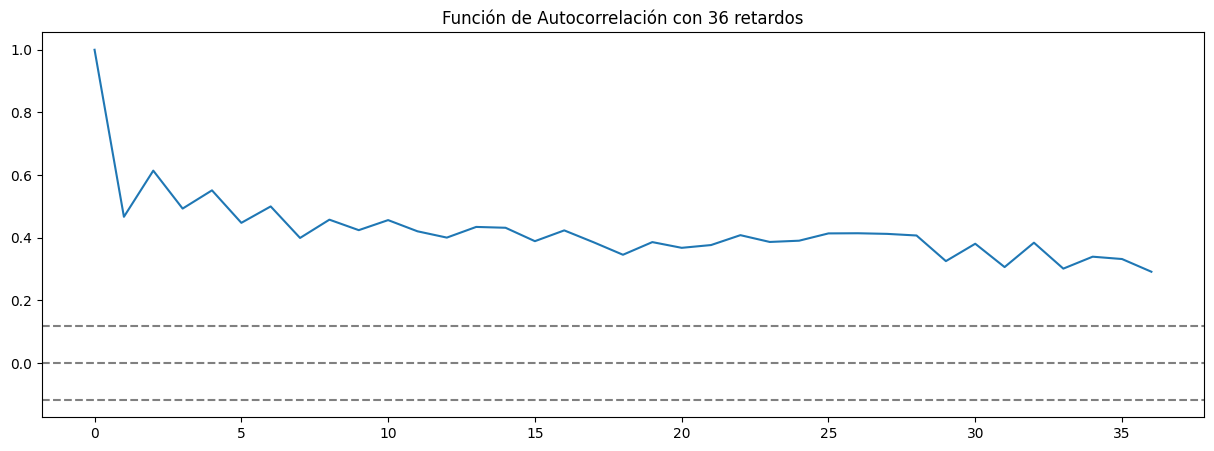

In [473]:
plt.plot(acf(import_data,nlags=36,fft=False))
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(import_data)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(import_data)),linestyle='--',color='gray')
plt.title('Función de Autocorrelación con 36 retardos')
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

### Creating ARIMA models

In [474]:
model111 = ARIMA(import_data, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
resultado_m111 = model111.fit()
print(resultado_m111.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2259      0.062     -3.669      0.000      -0.347      -0.105
ma.L1         -0.7727      0.034    -22.807      0.000      -0.839      -0.706
sigma2      1.282e+10   2.02e-12   6.36e+21      0.000    1.28e+10    1.28e+10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [475]:
model211 = ARIMA(import_data, order=(2, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
resultado_m211 = model211.fit()
print(resultado_m211.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0917      0.060     -1.526      0.127      -0.210       0.026
ar.L2          0.2051      0.070      2.928      0.003       0.068       0.342
ma.L1         -0.9014      0.039    -23.079      0.000      -0.978      -0.825
sigma2      1.264e+10   2.68e-12   4.72e+21      0.000    1.26e+10    1.26e+10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [476]:
model311 = ARIMA(import_data, order=(3, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
resultado_m311 = model311.fit()
print(resultado_m311.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0893      0.059     -1.513      0.130      -0.205       0.026
ar.L2          0.2122      0.070      3.046      0.002       0.076       0.349
ar.L3          0.0214      0.072      0.299      0.765      -0.119       0.162
ma.L1         -0.9071      0.040    -22.760      0.000      -0.985      -0.829
sigma2      1.264e+10   2.67e-12   4.74e+21      0.000    1.26e+10    1.26e+10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [477]:
model411 = ARIMA(import_data, order=(4, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
resultado_m411 = model411.fit()
print(resultado_m411.summary().tables[1])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0832      0.061     -1.365      0.172      -0.203       0.036
ar.L2          0.2039      0.068      3.007      0.003       0.071       0.337
ar.L3          0.0327      0.073      0.447      0.655      -0.111       0.176
ar.L4          0.0792      0.065      1.220      0.222      -0.048       0.206
ma.L1         -0.9177      0.038    -23.941      0.000      -0.993      -0.843
sigma2       1.26e+10   2.45e-12   5.13e+21      0.000    1.26e+10    1.26e+10


In [478]:
model511 = ARIMA(import_data, order=(5, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
resultado_m511 = model511.fit()
print(resultado_m511.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0799      0.061     -1.303      0.193      -0.200       0.040
ar.L2          0.2046      0.067      3.039      0.002       0.073       0.336
ar.L3          0.0459      0.075      0.611      0.541      -0.101       0.193
ar.L4          0.0730      0.065      1.126      0.260      -0.054       0.200
ar.L5         -0.0667      0.067     -1.001      0.317      -0.197       0.064
ma.L1         -0.9131      0.039    -23.462      0.000      -0.989      -0.837
sigma2       1.24e+10   2.39e-12    5.2e+21      0.000    1.24e+10    1.24e+10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


### Checking the best parameters for prediction model

In [479]:
print("Resultados de AIC (Akaike information criterion)")
print("Modelo 111=",resultado_m111.aic)
print("Modelo 211=",resultado_m211.aic)
print("Modelo 311=",resultado_m311.aic)
print("Modelo 411=",resultado_m411.aic)
print("Modelo 511=",resultado_m511.aic)
print("Resultados de BIC (Bayesian information criterion)")
print("Modelo 111=",resultado_m111.bic)
print("Modelo 211=",resultado_m211.bic)
print("Modelo 311=",resultado_m311.bic)
print("Modelo 411=",resultado_m411.bic)
print("Modelo 511=",resultado_m511.bic)

Resultados de AIC (Akaike information criterion)
Modelo 111= 7225.008391042542
Modelo 211= 7219.143136337021
Modelo 311= 7195.548470792235
Modelo 411= 7170.466136745348
Modelo 511= 7145.941878200633
Resultados de BIC (Bayesian information criterion)
Modelo 111= 7235.880443561104
Modelo 211= 7233.63920636177
Modelo 311= 7213.650475120821
Modelo 411= 7192.166763331347
Modelo 511= 7171.23377494535


## Use of Prophet algorithm to test our results

In [480]:
from prophet import Prophet 

In [481]:
m = Prophet()

newData = pd.read_excel("IMPORTACION-VOLUMEN-2024-05.xlsx", parse_dates=["Fecha"], date_format="%Y-%m-%d ", skiprows=6, skipfooter=3)

# Assuming data['Gasolina superior'] and data['Fecha'] are pandas Series
series = newData[['Fecha','Gasolina superior']]

# Create a DataFrame from the two Series
dataframe = pd.DataFrame({
    'ds': series['Fecha'],
    'y': series['Gasolina superior']
})

m.fit(dataframe)

22:42:05 - cmdstanpy - INFO - Chain [1] start processing
22:42:05 - cmdstanpy - INFO - Chain [1] done processing


In [482]:
future = m.make_future_dataframe(periods=10)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
281,2024-05-02,473861.710734,329016.690064,607639.856549
282,2024-05-03,352682.614637,216247.931705,478695.983482
283,2024-05-04,244955.156848,105898.335208,390329.976401
284,2024-05-05,151931.018358,16089.254842,290557.674274
285,2024-05-06,74482.159625,-58861.893146,216224.377439
286,2024-05-07,13093.274386,-121270.244660,156718.343788
287,2024-05-08,-32135.423985,-171535.357201,107897.634364
288,2024-05-09,-61475.376895,-206803.169453,63160.285439
289,2024-05-10,-75547.385102,-208485.688381,60753.758353
290,2024-05-11,-75290.669503,-218666.399998,58354.427007


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


(17897.0, 19844.0)

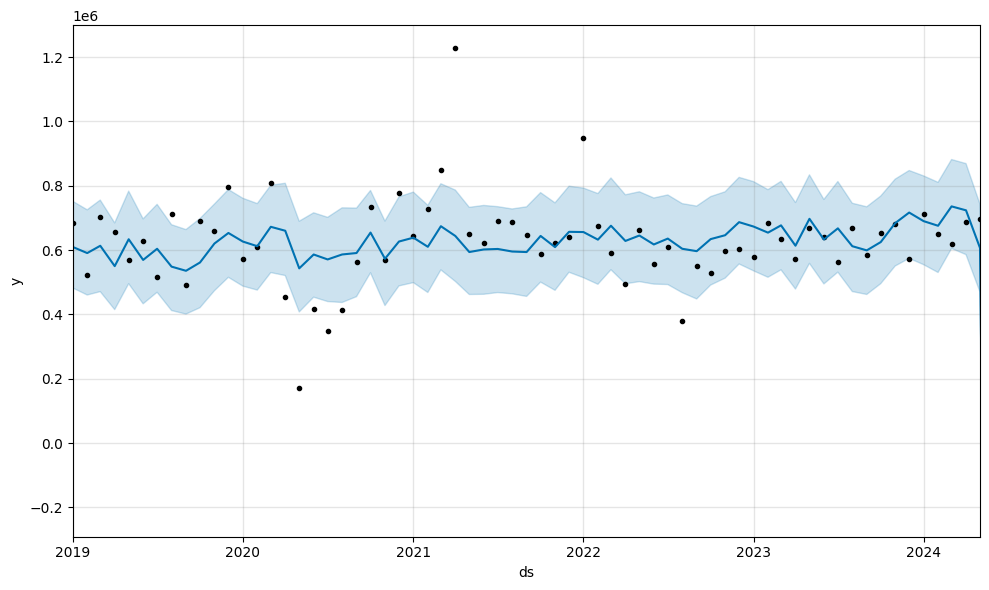

In [483]:
fig1 = m.plot(forecast)

ax = fig1.gca()
# setting x limit. date range to plot
ax.set_xlim(pd.to_datetime(['2019-01-01', '2024-05-01'])) 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will

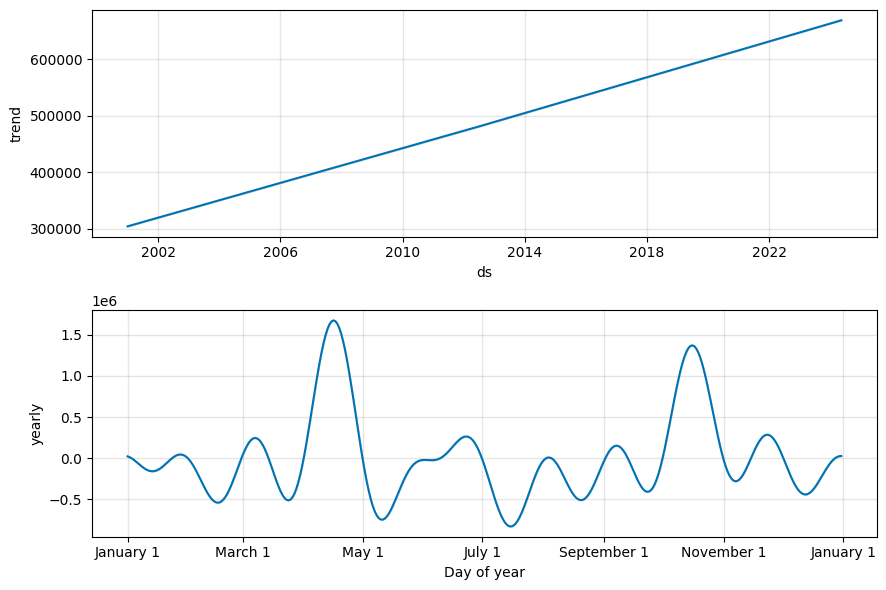

In [484]:
fig2 = m.plot_components(forecast)

## Predictions of the last 3 years with our best parameters

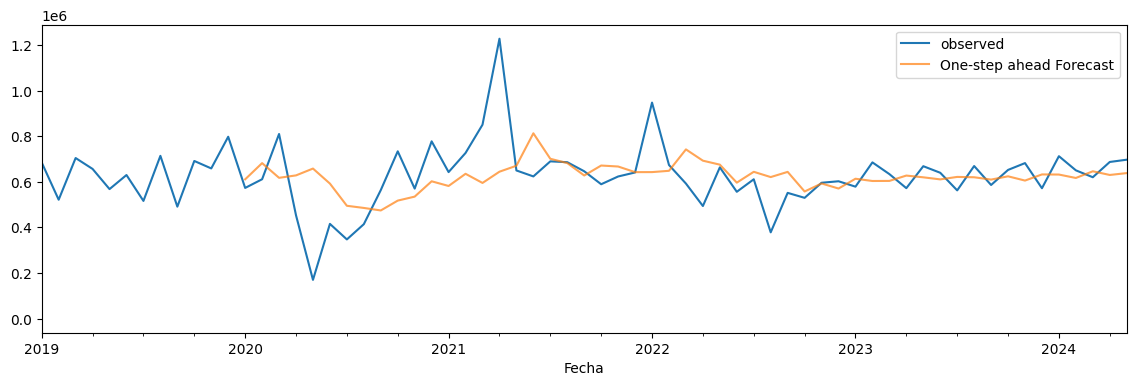

In [485]:
pred = resultado_m511.get_prediction(start=test_import_data.index[0], dynamic=False)
pred_ci = pred.conf_int()
ax = import_data['2019':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between( pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)
plt.legend()
plt.show()

pred

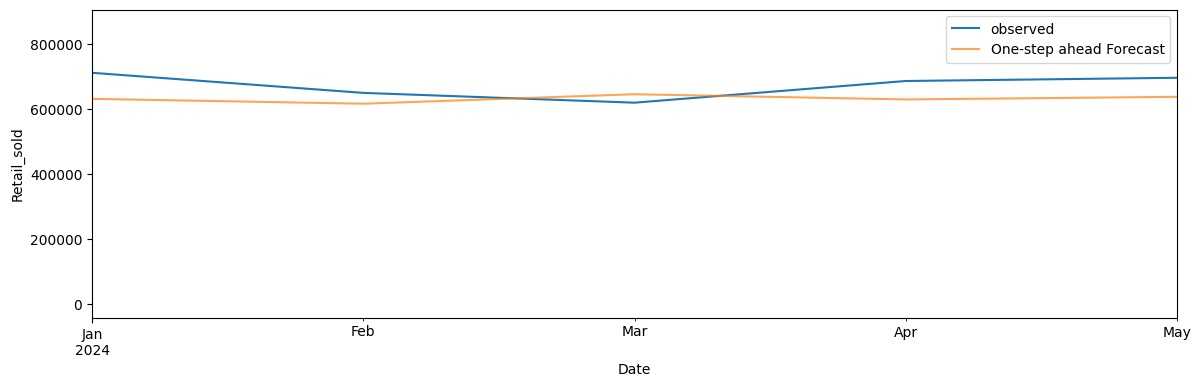

In [486]:
pred = resultado_m511.get_prediction(start=test_import_data.index[48], dynamic=False)
pred_ci = pred.conf_int()
ax = import_data['2024-01-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between( pred_ci.iloc[:,0],
                pred_ci.iloc[:,1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()